In [3]:
import sksurv

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

In [5]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

In [6]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.25, random_state=random_state)

In [7]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train) 

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [8]:
rsf.score(X_test, y_test)


0.6759696016771488

In [9]:
X_test_sorted = X_test.sort_values(by=["pnodes", "age"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
119,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0
574,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0
421,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0
24,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0
226,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0


In [10]:
pd.Series(rsf.predict(X_test_sel))


0     91.477609
1    102.897552
2     75.883786
3    170.502092
4    171.210066
5    148.691835
dtype: float64

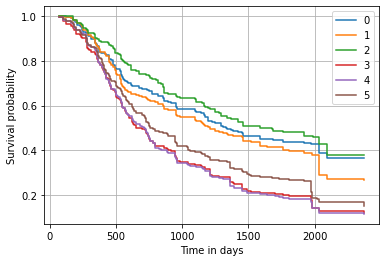

In [11]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)


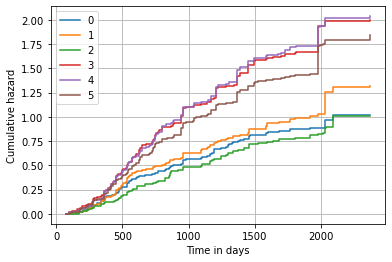

In [12]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)


In [14]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=random_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=Xt.columns.tolist())

Weight,Feature
0.0676 ± 0.0229,pnodes
0.0206 ± 0.0139,age
0.0177 ± 0.0468,progrec
0.0086 ± 0.0098,horTh=yes
0.0032 ± 0.0198,tsize
0.0032 ± 0.0060,tgrade
-0.0007 ± 0.0018,menostat=Post
-0.0063 ± 0.0207,estrec


## SHAP EXPLAINER:

In [17]:
import shap
explainer = shap.Explainer(rsf.predict, X_train, feature_names=Xt.columns.tolist())
shaps = explainer(X_test)

Exact explainer: 173it [3:19:06, 69.46s/it]                                                                            


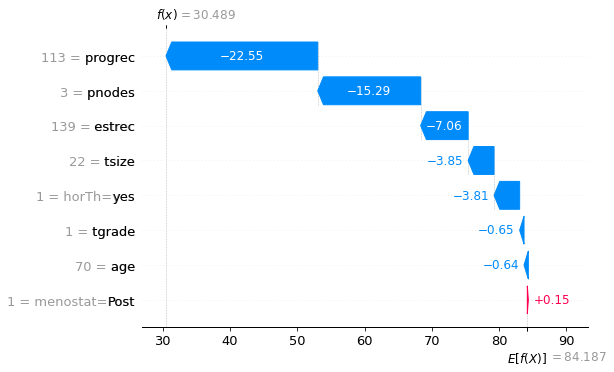

In [18]:
shap.plots.waterfall(shaps[0])
